# Classification 
***
## Idea: 
- We will classify the success of a game on Steam based on the features of the game
- Features: Ratings (`positive` & `negative` reviews), `average_playtime`, `owners`
- We will then use **0/1** to classify success through a new column `success` 

In [1]:
# Basic Libraries
import json
import statistics
import math

from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt  # we only need pyplot

sb.set()  # set the default Seaborn style for graphics

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import RandomForestClassifier

## 1. Importing Dataset

In [3]:
steam_df = pd.read_csv('Cleaned/steam_cleaned.csv')
print("Number of games:", len(steam_df))
steam_df.head(1)

Number of games: 62057


,appid,name,release_date,english,developer,publisher,platforms,categories,genres,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,01/11/2000,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,229766,5992,9847,169,10000000-20000000,10.0


In [4]:
steam_df.dtypes

appid                 int64
name                 object
release_date         object
english               int64
developer            object
publisher            object
platforms            object
categories           object
genres               object
steamspy_tags        object
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
median_playtime       int64
owners               object
price               float64
dtype: object

#### 1.1 Encoding categorical variables using OneHotEncoding
- We will first pre-process our categorical columns into binary encoded so that it will be easier to apply the machine learning techniques we used on these categorical columns

In [5]:
import itertools
import re
import math

def get_unique(series):

    return set(list(itertools.chain(*series.dropna().apply(lambda x: [c for c in x.split(';')]))))

def process_rating(row):
    
    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg

    # Check for division by zero (no reviews)
    if total_reviews == 0:
          return 0  # Handle case with no reviews (set rating to 0)

    average = int(round(pos / total_reviews * 100))  # Round off to the nearest whole number and cast to integer
    return average  # Return the whole number rating

def process_genre(df):
    
    # Check unique values
    genres = get_unique(df['genres'])
    
    # List to store genre column names
    gen_col_names = []

    for gen in sorted(genres):
        # Replace spaces and special characters in genre name to create column name
        gen_name = gen.lower().replace('&', 'and').replace(' ', '_')
        gen_name = 'genre_' + gen_name
        gen_col_names.append(gen_name)
        # Create binary column for each genre
        df[gen_name] = df['genres'].apply(lambda x: 1 if gen in x.split(';') else 0)
        
    # Filter out rows where none of the genres are present
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
    return df

def process_steamspytags(df):
    
    # Check unique values
    tags = get_unique(df['steamspy_tags'])
    
    # List to store column names
    tag_col_names = []

    for tag in sorted(tags):
        # Replace spaces and special characters in tag name to create column name
        tag_name = tag.lower().replace('&', 'and').replace(' ', '_')
        tag_name = 'tag_' + tag_name
        tag_col_names.append(tag_name)
        # Create binary column for each tag
        df[tag_name] = df['steamspy_tags'].apply(lambda x: 1 if tag in x.split(';') else 0)
        
    # Filter out rows where none of the tags are present
    tag_sums = df[tag_col_names].sum(axis=1)
    df = df[tag_sums > 0].copy()
    
    return df

def process_dev_pub(df):
    # Get the top 30 developers
    top_developers = df['developer'].value_counts().nlargest(30).index.tolist()
    
    # Get the top 30 publishers
    top_publishers = df['publisher'].value_counts().nlargest(30).index.tolist()
    
    # Create binary columns for top developers and publishers
    df['top_developer'] = df['developer'].apply(lambda x: 1 if x in top_developers else 0)
    df['top_publisher'] = df['publisher'].apply(lambda x: 1 if x in top_publishers else 0)
    
    return df


def pre_process():

    df = pd.read_csv('Cleaned/steam_cleaned.csv')
    
    df['rating'] = df.apply(process_rating, axis=1)
    
    #df['owners'] = df['owners'].str.split('-').apply(lambda x: x[1]).astype(int) 
    
    # convert release_date to datetime type and create separate column for release_year
    # df['release_date'] = df['release_date'].astype('datetime64[ns]')
    # df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # process genres
    df = process_genre(df)
    df = process_steamspytags(df)
    
    #process top 30 developers nad publishers
    #df = process_dev_pub(df)
    
    return df

In [6]:
steam_df = pre_process()

In [7]:
steam_df.head()

,appid,name,release_date,english,developer,publisher,platforms,categories,genres,steamspy_tags,...,tag_well-written,tag_werewolves,tag_western,tag_wholesome,tag_word_game,tag_world_war_i,tag_world_war_ii,tag_wrestling,tag_zombies,tag_e-sports
0,10,Counter-Strike,01/11/2000,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,01/04/1999,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,01/05/2003,1,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled;Family S...,Action,FPS;World War II;Multiplayer,...,0,0,0,0,0,0,1,0,0,0
3,40,Deathmatch Classic,01/06/2001,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,01/11/1999,1,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,...,0,0,0,0,0,0,0,0,0,0


In [8]:
column_names = steam_df.columns.tolist()
print(column_names)

['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'categories', 'genres', 'steamspy_tags', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price', 'rating', 'genre_accounting', 'genre_action', 'genre_adventure', 'genre_animation_and_modeling', 'genre_audio_production', 'genre_casual', 'genre_design_and_illustration', 'genre_early_access', 'genre_education', 'genre_free_to_play', 'genre_game_development', 'genre_gore', 'genre_indie', 'genre_massively_multiplayer', 'genre_movie', 'genre_nudity', 'genre_photo_editing', 'genre_rpg', 'genre_racing', 'genre_sexual_content', 'genre_simulation', 'genre_software_training', 'genre_sports', 'genre_strategy', 'genre_utilities', 'genre_video_production', 'genre_violent', 'genre_web_publishing', 'tag_1980s', "tag_1990's", 'tag_2.5d', 'tag_2d', 'tag_2d_fighter', 'tag_2d_platformer', 'tag_360_video', 'tag_3d', 'tag_3d_fighter', 'tag_3d_platformer', 'tag_3d_vision', 'tag_4_play

#### 1.2 Success Threshold Formulation

We will use the median of all the `ratings` as our threshold

In [9]:
# Calculate median success score
overall_threshold = steam_df['rating'].median()
print(overall_threshold)

80.0


#### `average_playtime`

In [10]:
playtime_threshold = steam_df['average_playtime'].median()
print(playtime_threshold)

0.0


We will use the median average_playtime as our threshold
- average_playtime < 0.0 unsuccessful
- average_playtime > 0.0 successful

#### `overall_rating`
- Games with < 0.8 will be considered unsuccessful 
- Games with > 0.8 will be considered successful

In [11]:
# Split lower and upper bounds into a temporary DataFrame
steam_df[['lower_own', 'upper_own']] = steam_df['owners'].str.split('-', expand=True)
steam_df['lower_own'] = steam_df['lower_own'].astype(int)
steam_df['upper_own'] = steam_df['upper_own'].astype(int)
steam_df['owner_median'] = (steam_df['lower_own'] + steam_df['upper_own']) / 2
steam_df.head()

,appid,name,release_date,english,developer,publisher,platforms,categories,genres,steamspy_tags,...,tag_wholesome,tag_word_game,tag_world_war_i,tag_world_war_ii,tag_wrestling,tag_zombies,tag_e-sports,lower_own,upper_own,owner_median
0,10,Counter-Strike,01/11/2000,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,10000000,20000000,15000000.0
1,20,Team Fortress Classic,01/04/1999,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,5000000,10000000,7500000.0
2,30,Day of Defeat,01/05/2003,1,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled;Family S...,Action,FPS;World War II;Multiplayer,...,0,0,0,1,0,0,0,5000000,10000000,7500000.0
3,40,Deathmatch Classic,01/06/2001,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,...,0,0,0,0,0,0,0,5000000,10000000,7500000.0
4,50,Half-Life: Opposing Force,01/11/1999,1,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,...,0,0,0,0,0,0,0,2000000,5000000,3500000.0


In [12]:
owner_thresholdL = steam_df['lower_own'].median()
owner_thresholdU = steam_df['upper_own'].median()
owner_thresholdM = steam_df['owner_median'].median()

print('Median threshold for the lower bound of owners:', owner_thresholdL)
print('Median threshold for the upper bound of owners:', owner_thresholdU)
print('Median threshold for the median of owners:', owner_thresholdM)

Median threshold for the lower bound of owners: 0.0
Median threshold for the upper bound of owners: 20000.0
Median threshold for the median of owners: 10000.0


In [13]:
owner_threshold = steam_df['upper_own'].median()
print(owner_threshold)

20000.0


#### `owners`
- We will use the **median threshold** for the upper bound to indicate the success of a game
  - Owners < 20,000 unsuccessful
  - Owners > 20,000 successful 

#### 1.3 Measuring Success
- 0: Indicates unsuccessful
- 1: Indicates Successful
  - `rating` above 80.0
  - `average_playtime` above 0.0
  - `owners` above 20,000

In [14]:
# create 'success' column
steam_df['success'] = np.nan

for row in range(len(steam_df)):
    success = (steam_df['rating'][row] > 80.0 or 
              steam_df['average_playtime'][row] > 0.0 or
              steam_df['upper_own'][row] > 20000)
    
    if success:
        steam_df['success'][row] = 1
    else:
        steam_df['success'][row] = 0

In [15]:
steam_df.head()

,appid,name,release_date,english,developer,publisher,platforms,categories,genres,steamspy_tags,...,tag_word_game,tag_world_war_i,tag_world_war_ii,tag_wrestling,tag_zombies,tag_e-sports,lower_own,upper_own,owner_median,success
0,10,Counter-Strike,01/11/2000,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,...,0,0,0,0,0,0,10000000,20000000,15000000.0,1.0
1,20,Team Fortress Classic,01/04/1999,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,...,0,0,0,0,0,0,5000000,10000000,7500000.0,1.0
2,30,Day of Defeat,01/05/2003,1,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled;Family S...,Action,FPS;World War II;Multiplayer,...,0,0,1,0,0,0,5000000,10000000,7500000.0,1.0
3,40,Deathmatch Classic,01/06/2001,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,...,0,0,0,0,0,0,5000000,10000000,7500000.0,1.0
4,50,Half-Life: Opposing Force,01/11/1999,1,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,...,0,0,0,0,0,0,2000000,5000000,3500000.0,1.0


In [16]:
steam_df.dtypes

appid             int64
name             object
release_date     object
english           int64
developer        object
                 ...   
tag_e-sports      int64
lower_own         int32
upper_own         int32
owner_median    float64
success         float64
Length: 488, dtype: object

## 2. Functions for Modelling

#### 2.1 Classification
- a function that combines all the other functions made so that we can call all at once
- functions made are: confusion_matrix, precision_recall, f1_score, oob_score and ROC_AUC

In [17]:
def model_performance(random_forest, X_train, X_test, y_train, y_test):
    # Import libraries
    from sklearn.model_selection import cross_val_predict
    from sklearn.model_selection import cross_val_score
    
    # K-Fold Cross Validation
    y_train_pred = cross_val_predict(random_forest, X_train, y_train, cv=5)
    y_test_pred = cross_val_predict(random_forest, X_test, y_test, cv=5)
    
    train_scores = cross_val_score(random_forest, X_train, y_train, cv=5, scoring = "accuracy")
    test_scores = cross_val_score(random_forest, X_test, y_test, cv=5, scoring = "accuracy")
    
    print("-> Train Dataset")
    confusion_matrix_TPR_TNR(y_train, y_train_pred, train_scores, "Train")
    get_precision_recall(y_train, y_train_pred)
    get_f1_score(y_train, y_train_pred)

    print("\n\n-----\n-> Test Dataset")
    confusion_matrix_TPR_TNR(y_test, y_test_pred, test_scores, "Test")
    get_precision_recall(y_test, y_test_pred)
    get_f1_score(y_test, y_test_pred)
    ROC_AUC(random_forest, X_test, y_test, "Test")
    print('-----\n')
    
    try:
        get_oob_score(random_forest)
    except:
        pass

#### 2.1 Defining our confusion matrix 
A confusion matrix provides a summary of the predictions made by the model against the variable we wanted to predict

1. True Positives (TP): Cases where the model predicted the positive class correctly.
2. True Negatives (TN): Cases where the model predicted the negative class correctly.
3. False Positives (FP): Cases where the model predicted the positive class incorrectly.
4. False Negatives (FN): Cases where the model predicted the negative class incorrectly.

From the confusion matrix, performance metrics can be calculated to assess whether our model is effective or not. We will be using **CA, TPR, TNR**

In [18]:
def confusion_matrix_TPR_TNR(y, y_pred, scores, train_test_string):
    from sklearn.metrics import confusion_matrix # Confusion Matrix
    # Confusion Matrix
    c_matrix = confusion_matrix(y, y_pred)

    # True Negatives & True Positives
    TN = c_matrix[0][0]
    FP = c_matrix[1][0]
    FN = c_matrix[0][1]
    TP = c_matrix[1][1]

    # True Positive Rate and True Negative Rate
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)

    # Check the Goodness of Fit (on Train Data)
    print(f"Goodness of Fit of Model ({train_test_string} Dataset)")
    print("Classification Accuracy:", scores.mean())
    print("True Positive Rate:", TPR)
    print("True Negative Rate:", TNR)

    # Plot the Confusion Matrix
    plt.figure(figsize=(8, 8))
    sb.heatmap(c_matrix, 
               annot = True, 
               fmt=".0f", 
               annot_kws={"size": 18}).set(title=f"Confusion Matrix ({train_test_string} Dataset)")
    print()

#### 2.2 Precision Recall
- Precision is the ratio of true positive predicitons to the total number of positive predictions made by the model. It measures the model's ability to avoid false positives

In [19]:
def get_precision_recall(y, y_pred):
    from sklearn.metrics import precision_score, recall_score
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    
    print("Precision:", precision)
    print("Recall:", recall)
    
    return [precision, recall]

#### 2.3 F1 Score
- F1 is the harmonic mean of precision and recall and provides a balance between the 2 metrics
- It is used for evaluating the overall performance of our classification model 

In [20]:
def get_f1_score(y, y_pred):
    from sklearn.metrics import f1_score
    
    f1 = f1_score(y, y_pred)
    
    print("f1_score:", f1)
    
    return f1

#### 2.4 Out of Box Score
- The OOB score is a measure of the performance of a random forest classifier using the out-of-bag samples, which are not included in the bootstrap sample used to train each tree in the forest.
- It serves as an estimate of the model's performance on unseen data and can be useful for assessing the effectiveness of the random forest model without the need for a separate validation set.

In [21]:
def get_oob_score(random_forest):
    print("oob score:", round(random_forest.oob_score_ * 100, 2), "%")

#### 2.5 ROC & AUC
- Receiver Operating Characterisitic (ROC) curve visualises the trade-off between true positive rate and false positive rate 
- The Area Under the Curve (AUC) score quantifies the overall performance of the classifier

In [22]:
def ROC_AUC(random_forest, X_train, y_train, train_test):
    try:
        # getting the probabilities of our predictions
        y_scores = random_forest.predict_proba(X_train)
        y_scores = y_scores[:,1]

        from sklearn.metrics import roc_curve
        # compute true positive rate and false positive rate
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

        # plotting them against each other
        def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
            plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
            plt.plot([0, 1], [0, 1], 'r', linewidth=4)
            plt.axis([0, 1, 0, 1])
            plt.xlabel('False Positive Rate (FPR)', fontsize=16)
            plt.ylabel('True Positive Rate (TPR)', fontsize=16)
            plt.title(f'{train_test} Dataset')

        plt.figure(figsize=(14, 7))
        plot_roc_curve(false_positive_rate, true_positive_rate)
        plt.show()


        # ROC AUC Score
        from sklearn.metrics import roc_auc_score
        r_a_score = roc_auc_score(y_train, y_scores)
        print("ROC-AUC-Score:", r_a_score)
    except:
        pass

# 3. Decision Tree
- We will use the Decision Tree to predict the `success` of a Steam game using the features of tags and genres
- The dataset is split into training and testing sets using a 70-30 split to assess the model's accuracy

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(steam_df['success'])
X = pd.DataFrame(steam_df.drop(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'categories', 
             'genres', 'steamspy_tags', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 
            'price', 'owners', 'success', 'lower_own', 'upper_own',	'owner_median', 'rating'], axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

y_test_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print("Train accuracy:", round(acc_decision_tree, 2), "%")

acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2)
print("Test accuracy:", round(acc_decision_tree, 2), "%")

Train accuracy: 84.76 %
Test accuracy: 66.15 %


-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.6600061087024685
True Positive Rate: 0.7357677190313173
True Negative Rate: 0.46135732907240773

Precision: 0.7357677190313173
Recall: 0.7837390687780666
f1_score: 0.7589961579334586


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.6339024723083176
True Positive Rate: 0.7239231178302818
True Negative Rate: 0.4263978001833181

Precision: 0.7239231178302818
Recall: 0.7528045504819086
f1_score: 0.7380814066070254


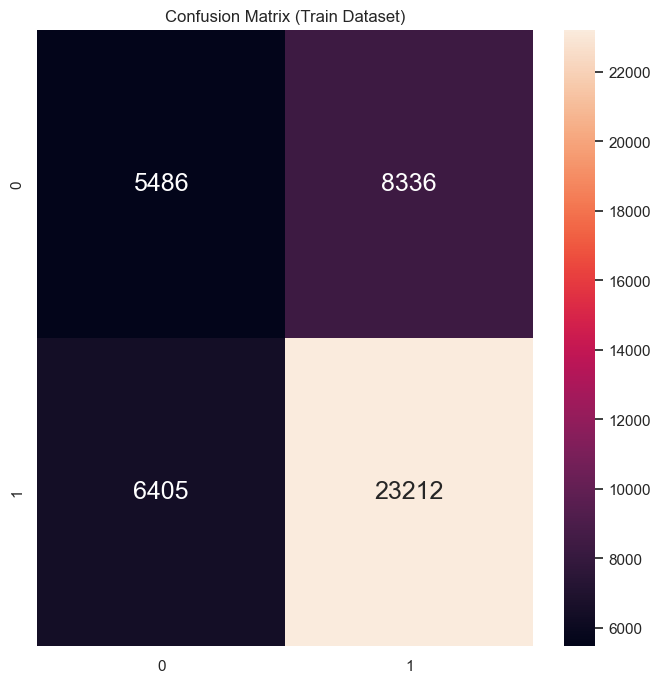

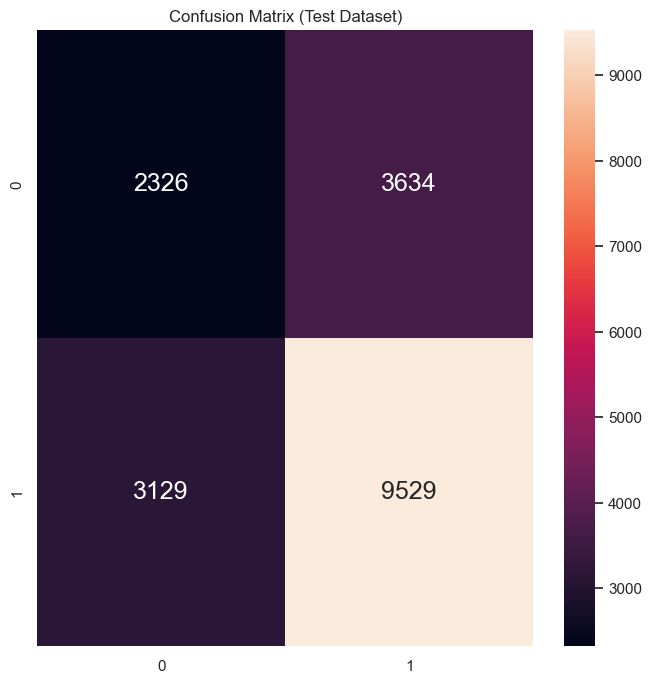

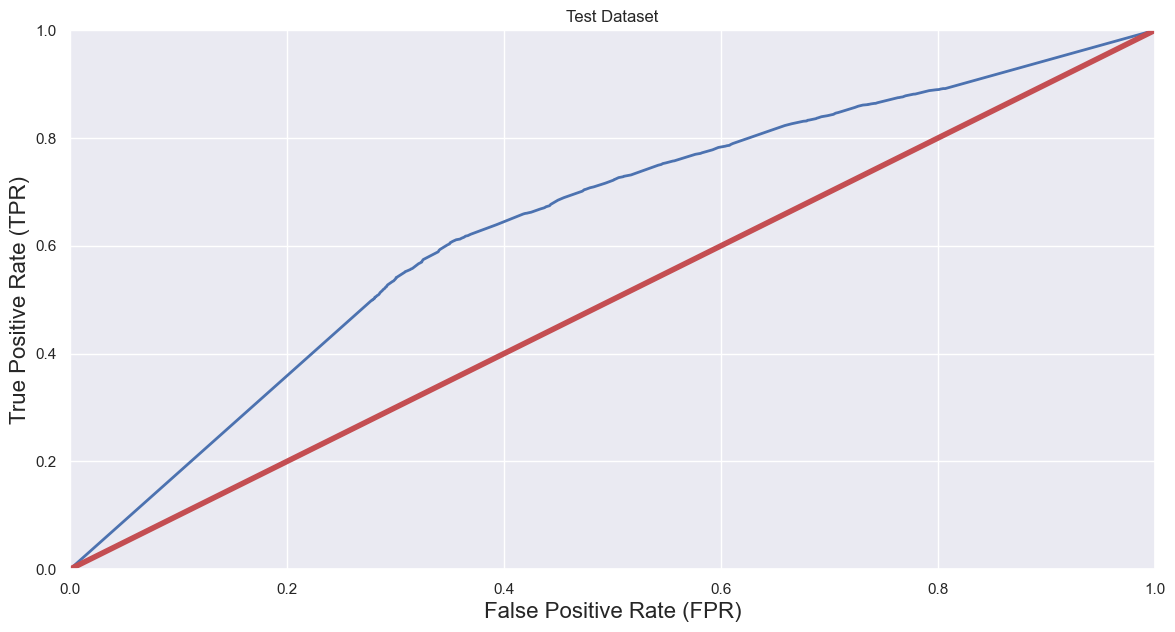

ROC-AUC-Score: 0.6414012187957638
-----



In [24]:
# test model performance with K-Fold Cross Validation (k=5)
model_performance(decision_tree, X_train, X_test, y_train, y_test)

#### Train Dataset 
- Classification Accuracy **(CA)** of about 66.00%, indicates that the model can predict 66% of the success of the game correctly
- **TPR** = ~73.57%, **TNR** = ~46.13%
- **Precision** = ~73.57%, indicating that around 73% of the positive predictions made by our model are correct.
- **Recall** = ~78.37%, indicating that our model can identify 78% of positive instances, success of the game
- **F1_Score** = ~75.89%, reflecting the harmonic mean of precision and recall.

#### Test Dataset 
- Classification Accuracy **(CA)** of about ~63.39%, indicates that the model can predict 63% of the success of the game correctly
- **TPR** = ~72.39%, **TNR** = ~42.63%
- **Precision** = ~72.39 %, indicating that around 72% of the positive predictions made by our model are correct.
- **Recall** = ~75.28%, indicating that our model can identify 75% of positive instances, success of the game
- **F1_Score** = ~73.8%, reflecting the harmonic mean of precision and recall.

#### ROC-AUC Score
- ROC-AUC score for this model is **~64.1%**
- This suggests a moderate level of performance of our Decision Tree model


# 2. Random Forest Version 1

In [25]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Extract Response and Predictors
y = pd.DataFrame(steam_df['success'])
X = pd.DataFrame(steam_df.drop(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'categories', 
             'genres', 'steamspy_tags', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 
            'price', 'owners', 'success', 'lower_own', 'upper_own',	'owner_median', 'rating'], axis=1))
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [26]:
print("Length")
print(f"X_train:\t {len(X_train)}")
print(f"X_test: \t {len(X_test)}")
print(f"y_train:\t {len(y_train)}")
print(f"y_test: \t {len(y_test)}")

Length
X_train:	 43439
X_test: 	 18618
y_train:	 43439
y_test: 	 18618


In [27]:
# Random Forest
rfv1 = RandomForestClassifier(n_estimators=100, oob_score=True)
rfv1.fit(X_train, y_train)

y_pred = rfv1.predict(X_test)

rfv1.score(X_train, y_train)
acc_rfv1 = round(rfv1.score(X_train, y_train) * 100, 2)
print(round(acc_rfv1, 2), "%")


acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of {rfv1} is {acc}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix of {rfv1} is {cm}")

84.83 %
Accuracy of RandomForestClassifier(oob_score=True) is 0.6938983779138468
Confusion Matrix of RandomForestClassifier(oob_score=True) is [[ 1991  4039]
 [ 1660 10928]]


In [28]:
acc_rfv1 = round(rfv1.score(X_train, y_train) * 100, 2)
print("Train accuracy:", round(acc_rfv1, 2), "%")

acc_rfv1 = round(rfv1.score(X_test, y_test) * 100, 2)
print("Test accuracy:", round(acc_rfv1, 2), "%")

Train accuracy: 84.83 %
Test accuracy: 69.39 %


#### 4.1 K-Fold Cross Validation 5

In [29]:
scores = cross_val_score(rfv1, X_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.69440608 0.68991713 0.69429098 0.69003223 0.69506159]
Mean: 0.6927415990236252
Standard Deviation: 0.002274718854996402


-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.6931328877573886
True Positive Rate: 0.7314183935992763
True Negative Rate: 0.5270203272186416

Precision: 0.7314183935992763
Recall: 0.8714588877286354
f1_score: 0.7953210980970826


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.6691905601461926
True Positive Rate: 0.7162526997840173
True Negative Rate: 0.4802735402419779

Precision: 0.7162526997840173
Recall: 0.8430251032729583
f1_score: 0.7744854765727631


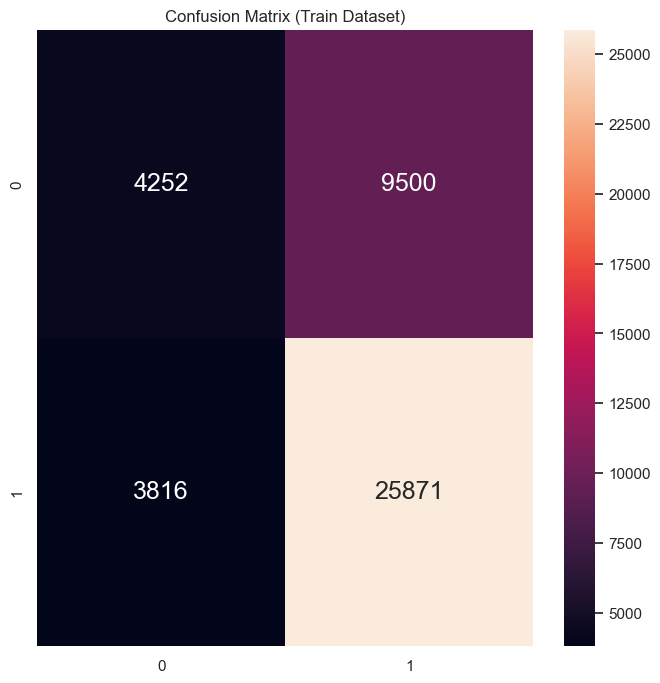

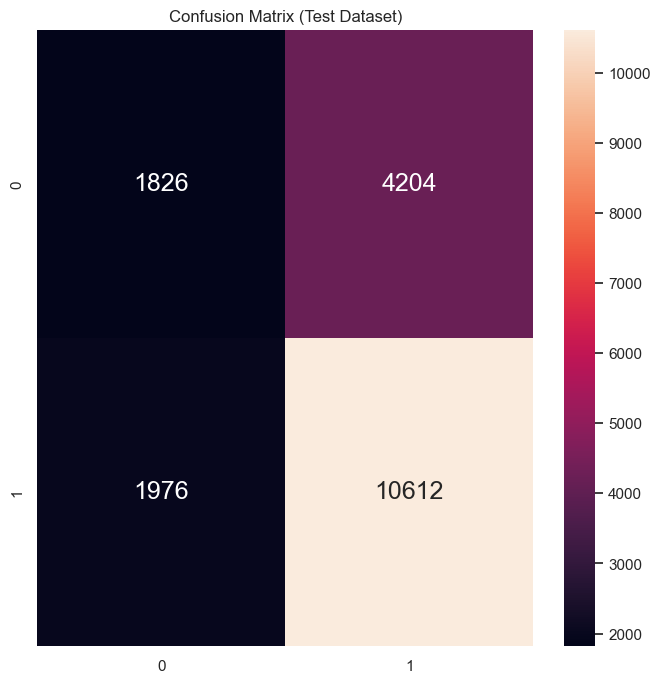

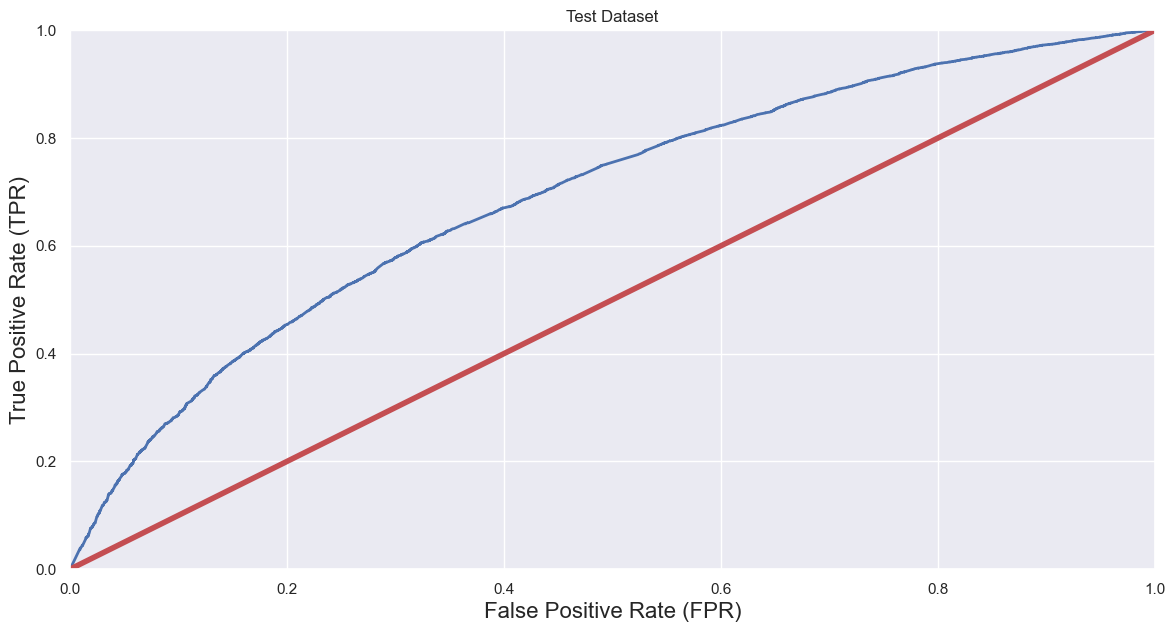

ROC-AUC-Score: 0.6902766645535168
-----

oob score: 69.61 %


In [30]:
model_performance(rfv1, X_train, X_test, y_train, y_test)

#### Train Dataset 
- Classification Accuracy **(CA)** of about ~69.31%, indicates that the model can predict 69% of the success of the game correctly
- **TPR** = ~73.14%, **TNR** = ~52.70%
- **Precision** = ~73.14%, indicating that around 73% of the positive predictions made by our model are correct.
- **Recall** = ~87.14%, indicating that our model can identify 87% of positive instances, success of the game
- **F1_Score** = ~79.53%, reflecting the harmonic mean of precision and recall.

#### Test Dataset 
- Classification Accuracy **(CA)** of about ~66.91%, indicates that the model can predict 66% of the success of the game correctly
- **TPR** = ~71.62%, **TNR** = ~48.02%
- **Precision** = ~71.62%, indicating that around 71% of the positive predictions made by our model are correct.
- **Recall** = ~84.30%, indicating that our model can identify 84% of positive instances, success of the game
- **F1_Score** = ~77.44%, reflecting the harmonic mean of precision and recall.

#### ROC-AUC Score
- ROC-AUC score for this model is **~69.02%**
- This suggests a moderate level of performance of our Decision Tree model

#### Evaluation (RF V1 vs Decision Tree):

Train Data:
- Increased Classification accuracy: 66% to ~69.31%
- Decreased TPR slightly: ~73.57% to ~73.14%
- Increased TNR significantly: ~46.13% to ~52.70%
- Increased f1_score: ~75.89% to ~79.53%

Test Data:
- Increased Classification accuracy: ~63.39% to ~66.91%
- Increased TPR: ~72.39% to ~71.62%
- Increased TNR significantly: ~42.63% to ~48.02%
- Increased f1_score: ~73.8% to ~77.44%

ROC-AUC Score increased from ~64.1% to ~69.02%

#### Random Forest
Using a random forest algorithm, it will randomise the model while making the tree. It searches for the best feature while splitting a node. Using K-Fold Cross Validation of 5, we built 5 different trees using random forest which is then combined to form the best optimal tree we can get. 

#### 4.2 Filtering Important Features
To try and improve our random forest, we will be dropping all features that have 0 importance in determining the accuracy and optimal outcome of our tree

In [31]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rfv1.feature_importances_, 3)})
importances = importances.sort_values('importance',ascending=False).reset_index(drop=True)

In [32]:
importances.head(15)

,feature,importance
0,genre_indie,0.038
1,genre_adventure,0.032
2,genre_casual,0.027
3,genre_strategy,0.026
4,genre_action,0.026
5,tag_indie,0.022
6,genre_rpg,0.022
7,genre_simulation,0.021
8,genre_early_access,0.019
9,tag_casual,0.017


<Axes: xlabel='feature'>

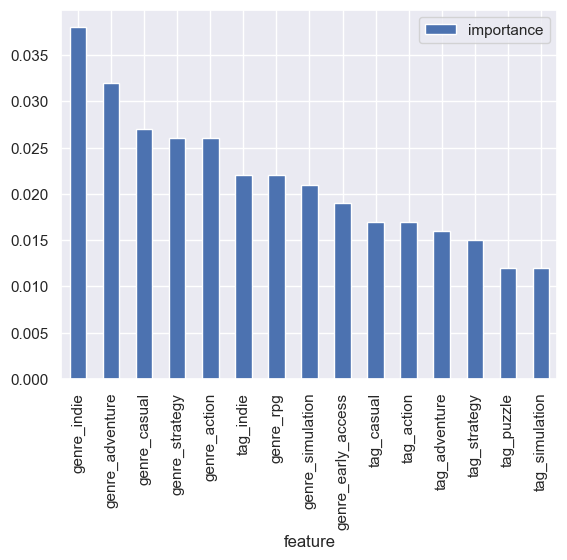

In [33]:
importances.head(15).plot.bar(x='feature', y='importance')

In [34]:
importances.tail(15)

,feature,importance
452,tag_instrumental_music,0.0
453,tag_mars,0.0
454,tag_intentionally_awkward_controls,0.0
455,tag_inventory_management,0.0
456,tag_jet,0.0
457,tag_job_simulator,0.0
458,tag_jump_scare,0.0
459,tag_kickstarter,0.0
460,tag_lego,0.0
461,tag_linear,0.0


In [35]:
zero_importance_features = []
for row in range(len(importances)):
    if importances['importance'][row] == 0:
        zero_importance_features.append(importances['feature'][row])
        
print('Number of features with 0 importance:', len(zero_importance_features))
print('Number of features with some importance:', len(importances) - len(zero_importance_features))

Number of features with 0 importance: 170
Number of features with some importance: 297


# 5. Random Forest Version 2
- after dropping not important features, build the tree again

In [36]:
cols_to_drop = ['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'categories', 
             'genres', 'steamspy_tags', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 
            'price', 'owners', 'success', 'lower_own', 'upper_own',	'owner_median', 'rating']
cols_to_drop.extend([col for col in zero_importance_features])
cols_to_drop

# Extract Response and Predictors
y = pd.DataFrame(steam_df['success'])
X = pd.DataFrame(steam_df.drop(cols_to_drop, axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [37]:
X_train.head(3)

,genre_action,genre_adventure,genre_animation_and_modeling,genre_audio_production,genre_casual,genre_design_and_illustration,genre_early_access,genre_education,genre_free_to_play,genre_game_development,...,tag_voxel,tag_walking_simulator,tag_war,tag_wargame,tag_western,tag_word_game,tag_world_war_ii,tag_wrestling,tag_zombies,tag_e-sports
41559,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10875,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Random Forest
rfv2 = RandomForestClassifier(n_estimators=100, oob_score = True)
rfv2.fit(X_train, y_train)

y_pred = rfv2.predict(X_test)

rfv2.score(X_train, y_train)
acc_rfv2 = round(rfv2.score(X_train, y_train) * 100, 2)
print(round(acc_rfv2,2,), "%")


acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(rfv2, acc))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix of %s is %s"%(rfv2, cm))

84.52 %
Accuracy of RandomForestClassifier(oob_score=True) is 0.6949726071543667
Confusion Matrix of RandomForestClassifier(oob_score=True) is [[ 1906  4020]
 [ 1659 11033]]


In [39]:
acc_rfv2 = round(rfv2.score(X_train, y_train) * 100, 2)
print("Train accuracy:", round(acc_rfv2, 2), "%")

acc_rfv2 = round(rfv2.score(X_test, y_test) * 100, 2)
print("Test accuracy:", round(acc_rfv2, 2), "%")

Train accuracy: 84.52 %
Test accuracy: 69.5 %


In [40]:
scores = cross_val_score(rfv2, X_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.68957182 0.68842081 0.68945672 0.68519797 0.6880396 ]
Mean: 0.6881373858102993
Standard Deviation: 0.0015829270696467786


-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.6881143682024388
True Positive Rate: 0.7280266757865937
True Negative Rate: 0.5164650940007185

Precision: 0.7280266757865937
Recall: 0.8635026873542238
f1_score: 0.7899986083406783


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.6804171416223302
True Positive Rate: 0.7265849902925621
True Negative Rate: 0.5004074979625102

Precision: 0.7265849902925621
Recall: 0.8551055783170501
f1_score: 0.7856238010785769


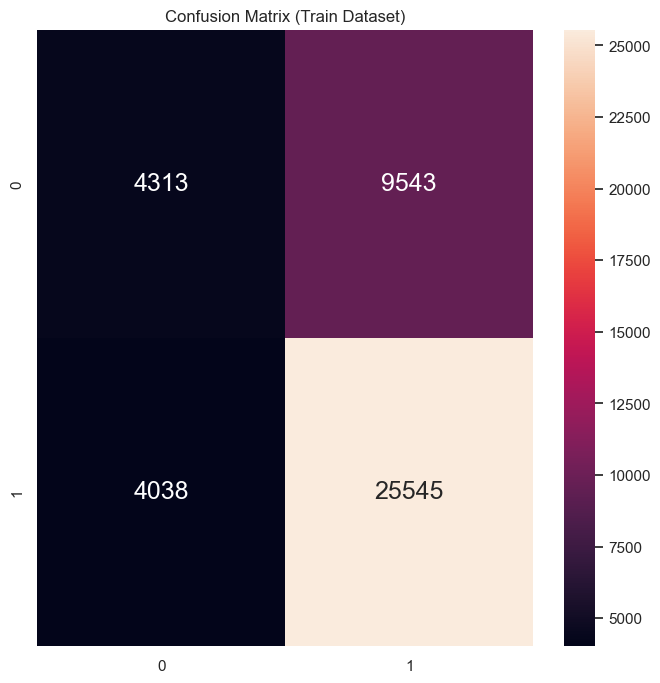

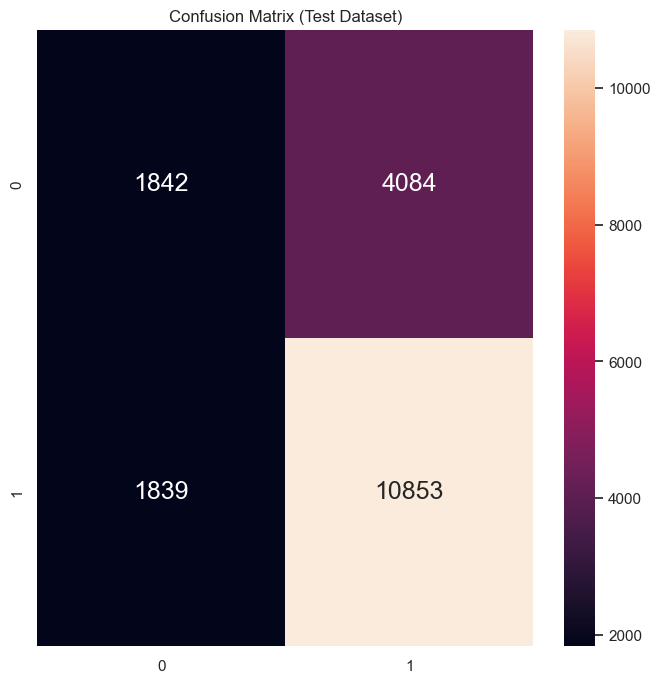

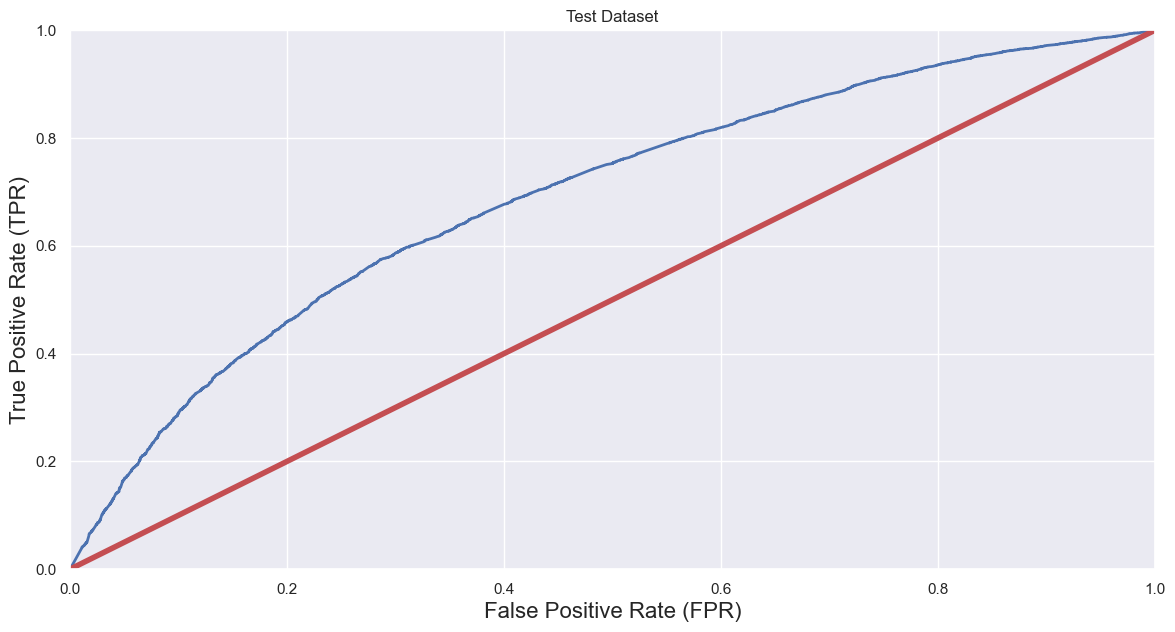

ROC-AUC-Score: 0.6901036860857392
-----

oob score: 69.2 %


In [41]:
model_performance(rfv2, X_train, X_test, y_train, y_test)

#### Train Dataset 
- Classification Accuracy **(CA)** of about ~68.81%, indicates that the model can predict 68% of the success of the game correctly
- **TPR** = ~72.8%, **TNR** = ~51.64%
- **Precision** = ~72.8%, indicating that around 73% of the positive predictions made by our model are correct.
- **Recall** = ~86.35%, indicating that our model can identify 86% of positive instances, success of the game
- **F1_Score** = ~78.99%, reflecting the harmonic mean of precision and recall.

#### Test Dataset 
- Classification Accuracy **(CA)** of about ~68.04%, indicates that the model can predict 68% of the success of the game correctly
- **TPR** = ~72.65%, **TNR** = ~50.04%
- **Precision** = ~72.65%, indicating that around 72% of the positive predictions made by our model are correct.
- **Recall** = ~85.51%, indicating that our model can identify 85% of positive instances, success of the game
- **F1_Score** = ~78.56%, reflecting the harmonic mean of precision and recall.

#### ROC-AUC Score
- ROC-AUC score for this model is **~69.01%**
- This suggests a moderate level of performance of our Decision Tree model

#### Evaluation (RF V1 vs RF V2):

Train Data:
- Decreased Classification accuracy: ~69.31% to ~68.81%
- Decreased TPR slightly: ~73.14% to ~72.8%
- Decreased TNR significantly: ~52.7% to ~51.64%
- Decreased f1_score: ~79.53% to ~78.99%

Test Data:
- Increased Classification accuracy: ~66.91% to ~68.04%
- Increased TPR: ~71.62% to ~72.65%
- Increased TNR significantly: ~48.02% to ~50.04%
- Increased f1_score: ~77.44% to ~78.56%

ROC-AUC Score similar: ~69.02% to ~69.01%

#### Conclusion
- Although the model metrics when predicting on Train data for Random Forest Version 1 are better than Random Forest Version 2, the opposite happens when testing the model on the Test data. The ROC-AUC for both random forests are similar.
- We will use Random Forest Version 2 as the best version for now since we feel its more important for the model to predict on the test data accurately.

# 6. Random Forest Version 3
- after dropping the 0 importance columns, we will now include the top 50 most important columns

In [42]:
# Extract Response and Predictors
y = pd.DataFrame(steam_df['success'])
X = pd.DataFrame(steam_df[list(importances['feature'].head(50))]) # Top 50 important features

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [43]:
# Random Forest
rfv3 = RandomForestClassifier(n_estimators=100, oob_score = True)
rfv3.fit(X_train, y_train)

y_pred = rfv3.predict(X_test)

rfv3.score(X_train, y_train)
acc_rfv3 = round(rfv3.score(X_train, y_train) * 100, 2)
print(round(acc_rfv3, 2), "%")

acc = accuracy_score(y_test, y_pred)
print("Accuracy of %s is %s"%(rfv3, acc))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix of %s is %s"%(rfv3, cm))

77.66 %
Accuracy of RandomForestClassifier(oob_score=True) is 0.6859490815339994
Confusion Matrix of RandomForestClassifier(oob_score=True) is [[ 1468  4485]
 [ 1362 11303]]


In [44]:
acc_rfv3 = round(rfv3.score(X_train, y_train) * 100, 2)
print("Train accuracy:", round(acc_rfv3, 2), "%")

acc_rfv3 = round(rfv3.score(X_test, y_test) * 100, 2)
print("Test accuracy:", round(acc_rfv3, 2), "%")

Train accuracy: 77.66 %
Test accuracy: 68.59 %


In [45]:
scores = cross_val_score(rfv3, X_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.68278085 0.68462247 0.68542818 0.68001842 0.68239899]
Mean: 0.6830497789822052
Standard Deviation: 0.0018875985279553295


-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.6838555118558436
True Positive Rate: 0.7152104443776801
True Negative Rate: 0.49838851450336946

Precision: 0.7152104443776801
Recall: 0.8843633907463695
f1_score: 0.7908430605680806


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.6739173535311745
True Positive Rate: 0.7153446033810144
True Negative Rate: 0.48641136504014826

Precision: 0.7153446033810144
Recall: 0.8686932491117252
f1_score: 0.7845961847031557


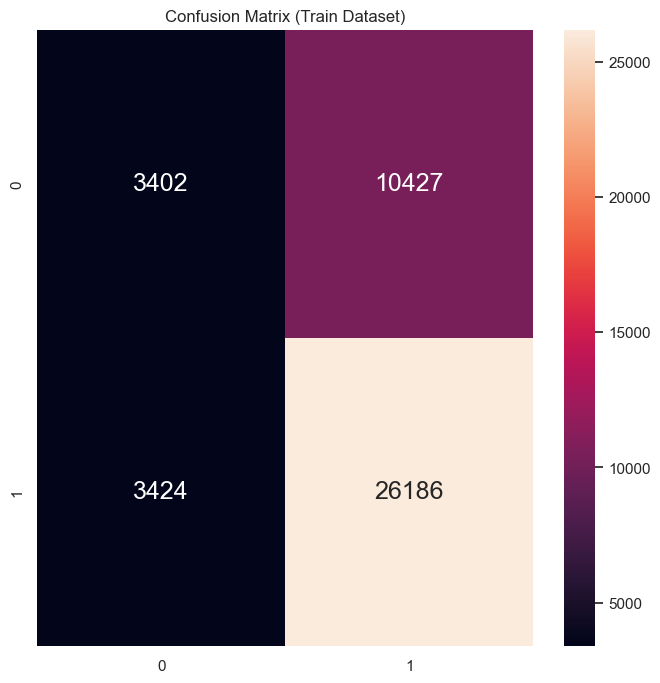

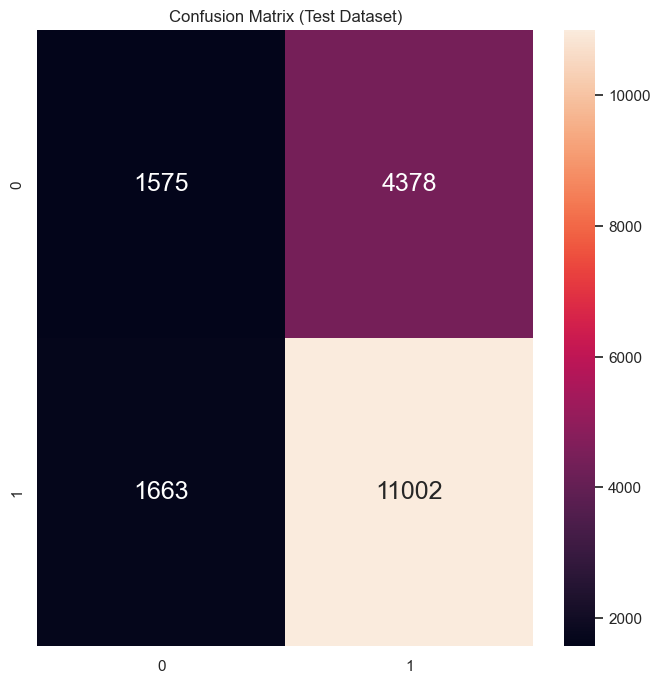

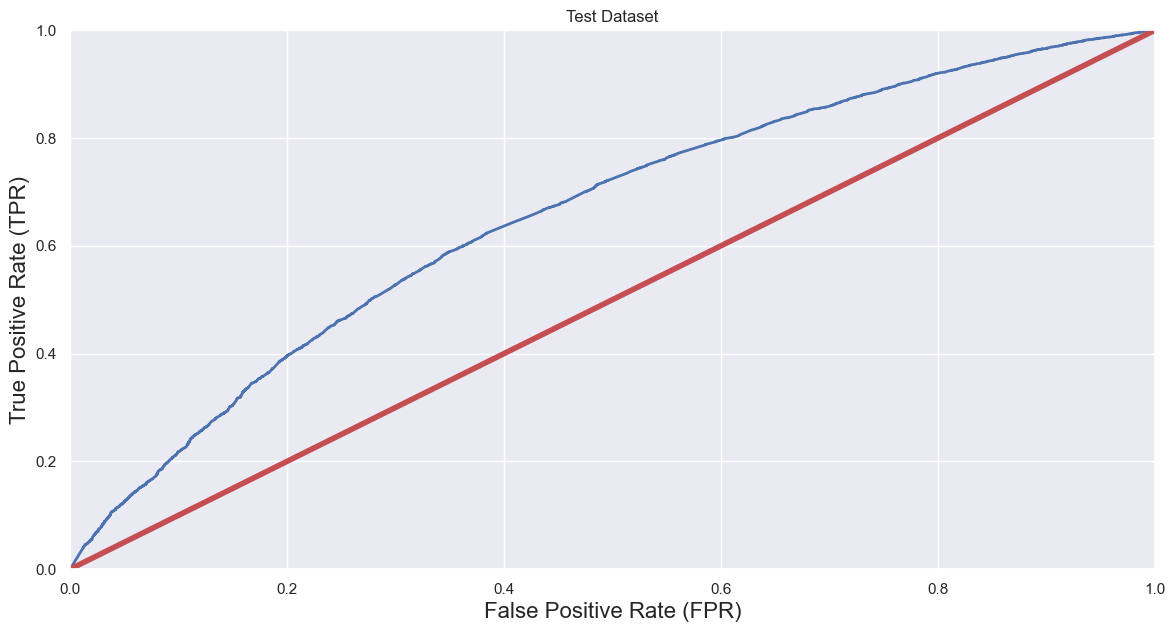

ROC-AUC-Score: 0.6563755736556971
-----

oob score: 68.52 %


In [46]:
model_performance(rfv3, X_train, X_test, y_train, y_test)

#### Train Dataset 
- Classification Accuracy **(CA)** of about ~68.38%, indicates that the model can predict 68% of the success of the game correctly
- **TPR** = ~71.52%, **TNR** = ~49.83%
- **Precision** = ~71.52%, indicating that around 71% of the positive predictions made by our model are correct.
- **Recall** = ~88.43%, indicating that our model can identify 88% of positive instances, success of the game
- **F1_Score** = ~79.08%, reflecting the harmonic mean of precision and recall.

#### Test Dataset 
- Classification Accuracy **(CA)** of about ~67.39%, indicates that the model can predict 67% of the success of the game correctly
- **TPR** = ~71.53%, **TNR** = ~48.64%
- **Precision** = ~71.53%, indicating that around 71% of the positive predictions made by our model are correct.
- **Recall** = ~86.86%, indicating that our model can identify 86% of positive instances, success of the game
- **F1_Score** = ~78.45%, reflecting the harmonic mean of precision and recall.

#### ROC-AUC Score
- ROC-AUC score for this model is **~65.63%**
- This suggests a moderate level of performance of our Decision Tree model

#### Evaluation (RF V2 vs RF V3):

Train Data:
- Decreased Classification accuracy: ~68.81% to ~68.38%
- Decreased TPR slightly: ~72.8% to ~71.52%
- Decreased TNR significantly: ~51.64% to ~49.83%
- Increased f1_score: ~78.99% to ~79.08%

Test Data:
- Decreased Classification accuracy: ~68.04% to ~67.39%
- Decreased TPR: ~72.65% to ~71.53%
- Decreased TNR significantly: ~50.04% to ~48.64%
- Decreased f1_score: ~78.56% to ~78.45%

ROC-AUC Score decreased: ~69.01% to ~65.63%

#### Conclusion
- Both model metrics when predicting on Train and Test data for Random Forest Version 3 are worse than Random Forest Version 2
- We will continue using Random Forest Version 2 as the best version for now 

# 7. Conclusion
- Random Forest Version 2 is the best model to predict the success of Steam Games
- The variables below are the most important and relevant when predicting the success of Steam Games

#### Model Test CA Score
1. Random Forest Version 2: 69.50
2. Random Forest Version 1: 69.39
3. Random Forest Version 3: 68.59
4. Decision Tree: 66.15   
#### Important variables: 
1. genre_indie	
2. genre_adventure
3. genre_casual
4. genre_stratey
5. genre_puzzzle